In [1]:
import os
from PIL import Image
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from utils import datasets
from utils import utils
from utils import train_val,train_val_for_det
from utils import net #网络文件于此
from utils import metrics
from utils.utils import Config,Logs,BestSelector
from utils import datasets_for_det

import warnings
# 完全禁用警告
warnings.filterwarnings("ignore")

In [2]:
config=utils.Config(
    dataset_sep=[
        0.82,0.17,0.01          
        ],
    resize_size=(500,500),#图像尺寸
    batch_size=2,
    lr=0.00003,
    epochs=5,#epoch轮数
    hidden_size=256,
    optim="Adam",
    momentum=0.9,
    weight_decay=1e-4,
    seed=42,
    mean= [0.50638 ,0.49962538 ,0.45205265],
    std=[0.23568255 ,0.24141274 ,0.25167742],
    AMP=True,
    checkpoint_interval=0.25,#只保存4个模型
    source_dir=r"COCO",#原始数据集，每个分类一个文件夹，每个文件夹里包含多个图片
    data_path=r"data\COCO",#项目数据集
    data_crop_rate=1,#只使用0.25
    # classes=["Apple","Carambola","Pear","Plum","Tomatoes"],
    device="cuda" if torch.cuda.is_available() else "cpu",
)

#### 加载COCO数据集

In [3]:
if "COCO" in config.data_path:
    '''
    原始标签
    [{'segmentation': [[]], 'area': 7207.7531500000005, 'iscrowd': 0, 'image_id': 336587, 'bbox': [247.66, 0.53, 94.92, 96.0], 'category_id': 13, 'id': 270138}, {'segmentation': [[]], 'area': 1305.6088499999978, 'iscrowd': 0, 'image_id': 336587, 
    'bbox': [605.96, 286.22, 33.82, 58.29], 'category_id': 8, 'id': 1796885}]
    '''
    transforms=datasets_for_det.ImagesAndBoxesTransform(
            #image和box同时resize
            resize_size=config.resize_size,
            mean=None,
            std=None
        )
    transform=torchvision.transforms.Compose([
        # torchvision.transforms.Resize(config.resize_size),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize(mean=None, std=None)
    ])
    import torchvision
    config.update(classes=datasets_for_det.COCO.COCO_CLASSES)
    def make_coco_path(tag,config=config):
        data_path=config.data_path
        return os.path.join(data_path,tag)
    train_val_dataset = torchvision.datasets.CocoDetection(
        root=make_coco_path("train2017"),
        annFile=make_coco_path("annotations/instances_train2017.json"),
        transforms=transforms
        # transform=transform
        )
    train_dataset,val_dataset=datasets.get_parts_of_datasets(train_val_dataset,rate=0.6,only_train=False)#训练验证3-1开
    test_dataset = torchvision.datasets.CocoDetection(
        root=make_coco_path("val2017"),
        annFile=make_coco_path("annotations/instances_val2017.json"),
        transforms=transforms
        # transform=transform
    )
    print(f"原始训练集大小：{len(train_dataset)}")
    print(f"原始验证集大小：{len(val_dataset)}")
    print(f"原始测试集大小：{len(test_dataset)}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
原始训练集大小：30
原始验证集大小：20
原始测试集大小：50


#### 加载 Pascal VOC 数据集

In [4]:
if "VOC" in config.data_path:
    import torchvision
    config.classes=datasets_for_det.PascalVOC.VOC_CLASSES
    train_val_dataset = torchvision.datasets.VOCDetection(
        root=config.data_path, 
        year='2012',
        image_set='trainval',
        # download=True, 
        transform=datasets.get_transform(
            chance="val",
            resize_size=config.resize_size,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    )
    train_dataset,val_dataset=datasets.get_parts_of_datasets(train_val_dataset,rate=0.75,only_train=False)#训练验证3-1开
    test_dataset = torchvision.datasets.VOCDetection(
            root=config.data_path,
            year='2012',
            image_set='val',
            transform=datasets.get_transform(
                chance="val",
                resize_size=config.resize_size,
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
    ))
    print(f"原始训练集大小：{len(train_dataset)}")
    print(f"原始验证集大小：{len(val_dataset)}")
    print(f"原始测试集大小：{len(test_dataset)}")

##### load数据集，并根据数据量进行裁剪。原数据集较大，本身为学习项目只取其中部分数据进行训练测试

In [5]:

crop_rate=config.data_crop_rate
train_dataset_crop=datasets.get_parts_of_datasets(train_dataset,crop_rate)
val_dataset_crop=datasets.get_parts_of_datasets(val_dataset,crop_rate)
test_dataset_crop=datasets.get_parts_of_datasets(test_dataset,crop_rate)
train_dataset_size=len(train_dataset_crop)
val_dataset_size=len(val_dataset_crop)
test_dataset_size=len(test_dataset_crop)

print(f"本次训练用训练集大小：{len(train_dataset_crop)}")
print(f"本次训练用验证集大小：{len(val_dataset_crop)}")
print(f"本次测试用测试集大小：{len(test_dataset_crop)}")
collate_fn=datasets_for_det.COCO.collate_fn
train_loader=DataLoader(train_dataset_crop,batch_size=config.batch_size,shuffle=True,drop_last=True,collate_fn=collate_fn)
val_loader=DataLoader(val_dataset_crop,batch_size=config.batch_size,shuffle=False,collate_fn=collate_fn)
test_loader=DataLoader(test_dataset_crop,batch_size=config.batch_size,shuffle=False,collate_fn=collate_fn)

print(f"tarin_dataloader加载完毕, {len(train_loader)}个batch, batch大小为{config.batch_size}")
print(f"val_dataloader  加载完毕, {len(val_loader)}个batch, batch大小为{config.batch_size}")
print(f"test_dataloader 加载完毕, {len(test_loader)}个batch, batch大小为{config.batch_size}")


本次训练用训练集大小：30
本次训练用验证集大小：20
本次测试用测试集大小：50
tarin_dataloader加载完毕, 15个batch, batch大小为2
val_dataloader  加载完毕, 10个batch, batch大小为2
test_dataloader 加载完毕, 25个batch, batch大小为2


#### 记录本次训练和测试用的数据量，还有数据样本信息和数据集标签对齐问题

tensor(0.) tensor(1.)
dict_keys(['boxes', 'labels'])
torch.Size([4, 4])


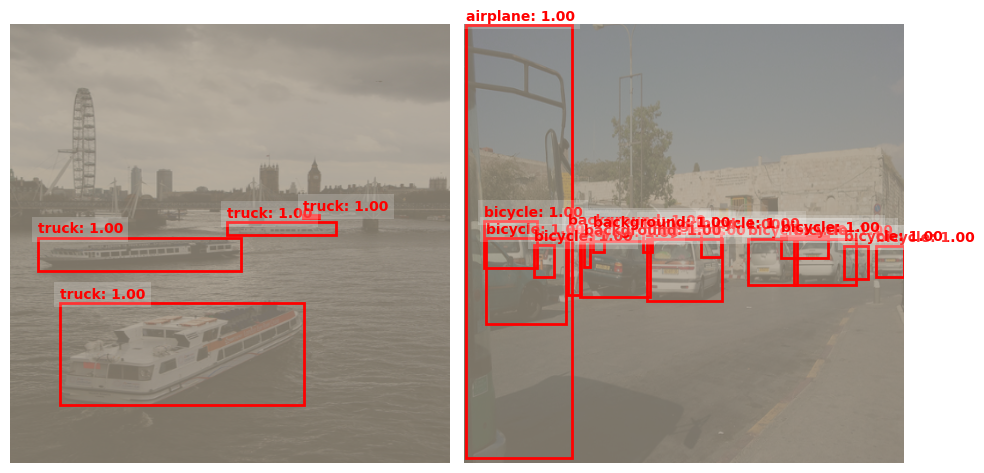

torch.Size([4, 4])
torch.Size([4])


In [6]:
#查看数据加载情况
'''
    outputs-预测结果：一个字典，包含 boxes 、labels和scores  。
    targets 真实标注：一个字典，包含 boxes和labels  。
 '''
from utils import prediction
def unnormalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # img: tensor (C, H, W)
    mean = torch.tensor(mean).view(-1, 1, 1).to(img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(img.device)
    return img * std + mean
import torchvision
# model=models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(config.device)
# model.eval()
category_names={idx:cls for idx,cls in enumerate(config.classes)}
cnt=1
mx=1
for images, targets in test_loader:
    if cnt<mx:
        cnt+=1
        continue
    '''
        images:[B,C,H,W]
        targets:{
            boxes:Tensor[N,4],
            labels:Tensor[N],
            }
        output :{
            "boxes": reg_preds, 
            "scores": scores, 
            "labels": labels
        }
    '''
    # images = [img.to(device) for img in images]
    print(images[0].min(), images[0].max())  # 检查数据范围
    print(targets[0].keys())
    print(targets[0]["boxes"].shape)
    prediction.visualize_batch(
        images=images,
        predictions=targets,
        unnormalize_fn=unnormalize,
        score_threshold=0.1,
        category_names=category_names,
        label_offset=-1
    )
    # images = torch.stack(images, dim=0).to(config.device)#一batch的图像[B,C,H,W]
    # targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets] #一batch的['boxes', 'labels']
    print(targets[0]["boxes"].shape)#[num,4]第i个图像有 num个box
    print(targets[0]["labels"].shape)#[num]num个box对应的分类
    config.update(inputs_shape=images.shape,)#[B,C,H,W]
    break
config.update(
    train_datasize=train_dataset_size,
    val_datasetsize=val_dataset_size,
    test_datasetsize=test_dataset_size,
)


#### 加载预训练模型

In [7]:
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_pretrained(config=config):
    '''
        获取预训练模型
        @param config: 配置文件
        @return: 预训练模型
    '''
    model=models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # in_features = model.roi_heads.box_predictor.cls_score.in_features
    # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(config.classes))
    return model.to(config.device)

model=get_pretrained()
measurer=metrics.ModelMeasurer(model)
unit=1
parameters_num,inference_time=measurer.simply_check_model(input_shape=config.inputs_shape,inference_repeation=50)
print(f"inference_time:{inference_time} s")
print(f"parameters_num:{parameters_num}")
config.update(
    network=model.__class__.__name__,
    inference_time=inference_time,
    parameters_num=parameters_num,
)
config

参数数量：41755286


Testing ...: 100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


推理一个batch的时间：0.1109047784423828 s
inference_time:0.1109047784423828 s
parameters_num:41755286


dataset_sep : [0.82, 0.17, 0.01] 
resize_size : (500, 500) 
batch_size : 2 
lr : 3e-05 
epochs : 5 
hidden_size : 256 
optim : Adam 
momentum : 0.9 
weight_decay : 0.0001 
seed : 42 
mean : [0.50638, 0.49962538, 0.45205265] 
std : [0.23568255, 0.24141274, 0.25167742] 
AMP : True 
checkpoint_interval : 0.25 
source_dir : COCO 
data_path : data\COCO 
data_crop_rate : 1 
device : cuda 
classes : ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'NULL_12', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'NULL_26', 'backpack', 'umbrella', 'NULL_29', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'NULL_45', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'brocc

#### 开始训练

In [8]:


# model=get_pretrained()
bestMod=utils.BestSelector(mAP=0,mAP_50=0,mAP_75=0,model=model,loss=-1)
train_logs=utils.Logs()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
if config.optim == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
else:
    optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=0.9, weight_decay=1e-4)
    
bestMod,train_logs=train_val_for_det.train_model(
            model=model, 
            criterion=None,
            optimizer=optimizer, 
            train_loader=train_loader,
            val_loader=val_loader,
            bestMod=bestMod,
            train_logs=train_logs,
            config=config, 
            checkpoint_interval=10,
            show_progress_interval=4,
            AMP=config.AMP,#是否使用混合精度训练
            multi_loss_weight=[1,0.3,0.3],
            lr_scheduler_step=0.7,#动态调整学习率
            # num_epochs=config.epochs
        )

训练检测模型的 Epoch:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]

Epoch 1/5, train_Loss: 0.7895, val_Loss: 0.0000, mAP: 0.3953
当前最好的模型: mAP : 0.3953 ,mAP_50 : 0.6534 ,mAP_75 : 0.4159 ,loss : 0.7895 ,epoch : 0 


训练检测模型的 Epoch: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]

Epoch 5/5, train_Loss: 0.3795, val_Loss: 0.0000, mAP: 0.3085
当前最好的模型: mAP : 0.3198 ,mAP_50 : 0.5660 ,mAP_75 : 0.3060 ,loss : 0.4245 ,epoch : 3 


In [9]:
print(f"{config.epochs} epoch中 最好的模型")
print(bestMod)

5 epoch中 最好的模型
mAP : 0.3198 ,mAP_50 : 0.5660 ,mAP_75 : 0.3060 ,loss : 0.4245 ,epoch : 3 


#### 保存模型超参数和训练日志

In [10]:
saveDir=r'save_weights'
saveDir=os.path.join(
        saveDir,
        f'{bestMod.model.__class__.__name__[:10]}-mAP={round(bestMod.mAP,4)}-max_epochs={config.epochs}'
)  
utils.saveProcess(
    saveDir=saveDir,
    bestMod=bestMod,
    train_log=train_logs,
    config=config
)

save_weights\FasterRCNN-mAP=0.3198-max_epochs=5
{'mAP': 0.3198299705982208, 'mAP_50': 0.5660206079483032, 'mAP_75': 0.30603548884391785, 'model': 'save_weights\\FasterRCNN-mAP=0.3198-max_epochs=5\\best.pth', 'loss': 0.4244553580880165, 'epoch': 3, 'checkpoints': {'checkpoint_0': 'save_weights\\FasterRCNN-mAP=0.3198-max_epochs=5\\checkpoint_0.pth'}}


#### 进行测试

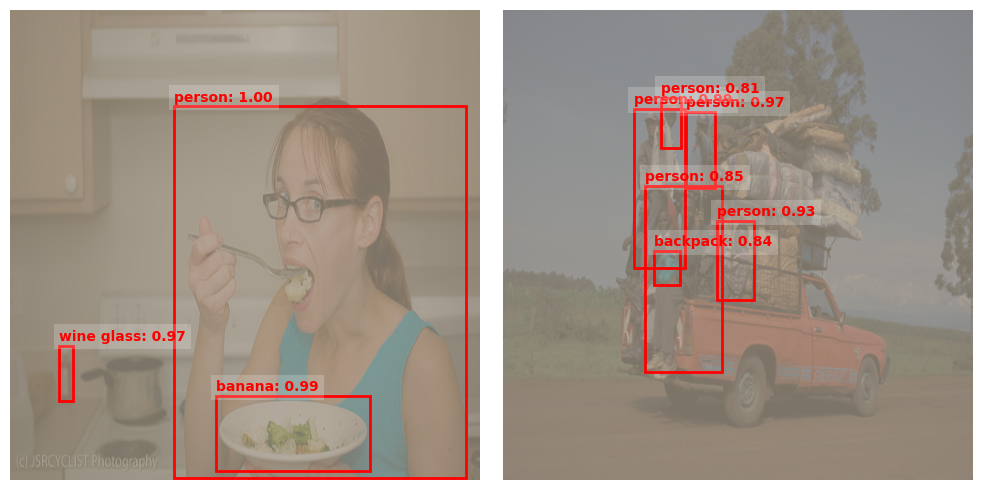

In [14]:
# 假设 images_tensor 为 tensor，形状 (N, C, H, W)
from utils import prediction
# 若图片经过归一化（例如均值和标准差归一化），可以定义 unnormalize_fn：
# 例如：假设均值=[0.485, 0.456, 0.406]，标准差=[0.229, 0.224, 0.225]
def unnormalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # img: tensor (C, H, W)
    mean = torch.tensor(mean).view(-1, 1, 1).to(img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(img.device)
    return img * std + mean
import torchvision
# model=models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(config.device)
model.eval()
category_names={idx:cls for idx,cls in enumerate(config.classes)}
cnt=1
mx=10
for images, targets in val_loader:
    if cnt<mx:
        cnt+=1
        continue
    images = images.to(config.device)#一batch的图像[B,C,H,W]
    targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets] #一batch的['boxes', 'labels']
    predictions = model(images)
    # print(predictions)
    prediction.visualize_batch(
        images=images,
        predictions=predictions,
        unnormalize_fn=unnormalize,
        score_threshold=0.8,
        category_names=category_names,
        label_offset=0
    )
    break
# 同时构造对应的预测结果



In [12]:
import torch
from utils import utils,train_val
import os

# config=Config(os.path.join(dir,'config.json'))
# model=BestSelector(os.path.join(dir,'metrics.json'))
# saveDir=r'save_weights\BinaryClassificationMobileNetV3Large-acc=0.74336-loss=1.671334-max_epochs=40-1100'
Model,config,logs=utils.loadProcess(saveDir=saveDir)
metrics=train_val_for_det.validate_model_detection(
    model=Model.model,
    val_loader=test_loader,
    device=config.device,
    only_val=True,
    criterion=None
)

metrics
for metric,value in metrics.items():
    print(f'{metric}:{value}')
    

模型验证中:: 100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


mAP:0.3483162820339203
mAP_50:0.5295906066894531
mAP_75:0.401655912399292
Loss:None


#### 保存数据到tensorboard

In [13]:
from utils import metrics,utils
recoder=metrics.TensorboardRecorder(#存到tensorboard显示
    log_dir="runs/",
    input_shape=[4,3,128,128],
    model=model

)
recoder.logs_scalars(
    logs.logs,
    prefix="train"
)